## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [89]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Load all test data into a singe dataframe

In [97]:
flutdf = pd.DataFrame()
names = {0:'Locked',1:'Free',2:'Free-IWT',3:'Free-IWT,IWB',4:'Free-IWT,IWB,FRotFWT',5:'Free-IWT,IWB,FRotFWT,Lin0',6:'Free-IWT,FRotFWT,Lin0'}

for i in range(7):
    dat = pd.read_pickle(f'Test_{i}.pkl')
    dat['Test'] = i
    flutdf = flutdf.append(dat,sort=False)

flutdf['Test'] = pd.Categorical(flutdf['Test'])
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])
flutdf = flutdf.reset_index(drop=True)

flutdf['Flare Angle [Deg]'] = pd.Categorical(flutdf['Flare Angle [Deg]'])
flutdf['AoA [Deg]'] = pd.Categorical(flutdf['AoA [Deg]'])
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['FWT Mass [%]'])
flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['FWT Ratio [%]'])

In [98]:
flutdf['FWT Mass [%]'].cat.categories

Float64Index([50.0, 100.0, 150.0], dtype='float64')

In [99]:
def iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True
    
def SeriesFilter(series,var):
    if iterable(var):
        return series.isin(var)
    else:
        return series == var

def GetReducedDataSet(flutdf,testNums,Flare=25,AoA=0,ratio_FWT=20,FWT_mass = 100,Vmax = 140):
    data = flutdf.copy()
    data = data[SeriesFilter(data['Test'],testNums)]
    data = data[SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[SeriesFilter(data['AoA [Deg]'],AoA)]
    data = data[SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[SeriesFilter(data['FWT Ratio [%]'],ratio_FWT)]
    data = data[data['V']<=Vmax]
    return data

In [100]:
d = GetReducedDataSet(flutdf,[4])
d.head()

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,q,delta_m,...,alpha_r,sigma,V,Damping [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg],FWT Mass [%],FWT Ratio [%],Test
595158,0.000000+2.476136j,0.000000e+00,2.476136,0.394089,6.123234e-17,False,"[(1.33485283005183e-22+7.25940713779615e-21j),...",0,"[-0.0012198963331013309, 0, 7.059585261003062e...",1.0,...,0.0,0.2,0.0,-6.123234e-15,90.0,25.0,0.0,100.0,20.0,4
595159,-0.000000+14.081791j,-3.671675e-11,14.081791,2.241187,-2.607409e-12,False,[(-3.910228433600326e-12+0.06384279514982534j)...,1,"[-0.0012198963331013309, 0, 7.059585261003062e...",1.0,...,0.0,0.2,0.0,2.607409e-10,90.0,25.0,0.0,100.0,20.0,4
595160,0.000000+47.924949j,4.026405e-09,47.924949,7.627493,8.401486e-11,False,[(7.519510194709896e-12-0.0004621787996167814j...,2,"[-0.0012198963331013309, 0, 7.059585261003062e...",1.0,...,0.0,0.2,0.0,-8.401486e-09,90.0,25.0,0.0,100.0,20.0,4
595161,-0.000000+105.575952j,-6.750303e-09,105.575952,16.802935,-6.393790e-11,False,[(1.0712212115757291e-12+0.004380135639627461j...,3,"[-0.0012198963331013309, 0, 7.059585261003062e...",1.0,...,0.0,0.2,0.0,6.393790e-09,90.0,25.0,0.0,100.0,20.0,4
595162,0.000000+151.886430j,5.553413e-09,151.886430,24.173476,3.656304e-11,False,[(-5.1932388527752406e-14+0.000325800550863897...,4,"[-0.0012198963331013309, 0, 7.059585261003062e...",1.0,...,0.0,0.2,0.0,-3.656304e-09,90.0,25.0,0.0,100.0,20.0,4


In [147]:
def PlotLines(data,Modes,hue,var,ax,sigma=8,legend=True):
    for i in Modes:
        ax.set_prop_cycle(None)
        dat = data[data['Mode']==i]
        unique_vars = np.unique(dat[hue])
        for j in unique_vars:
            dat_test = dat[dat[hue]==j]
            y = dat_test[var].to_numpy()            
            #clean up jumps in data
            ind = []
            for k in range(2,len(y)):
                delta_1 = np.abs(y[k]-y[k-1])
                delta_2 = np.abs(y[k-2]-y[k-1])       
                if (delta_2*sigma <delta_1):
                    ind.append(k-1)
            for index in ind:
                y[index] = np.NaN
            
            v = dat_test['V'].to_numpy()
            ax.plot(v,y)
        

def CoastDeltaPlot(data,hue, ax,Delta = True):# testNums,ax,Flare=25,AoA=0,FWT_ratio = 20,FWT_mass = 100,Vmax=140,Delta = True):
    # plot Coast Angle Changes
    dataMode0 =data[data['Mode']==0]
    unique_vars = np.unique(data[hue])
    
    a_1 = data[data[hue]==unique_vars[0]]['Coast Angle [Deg]'].to_numpy()
    v_1 = data[data[hue]==unique_vars[0]]['V'].to_numpy()
    a_2 = data[data[hue]==unique_vars[1]]['Coast Angle [Deg]'].to_numpy()
    v_2 = data[data[hue]==unique_vars[1]]['V'].to_numpy()
    
    vs = np.linspace(0,np.max(v_1),100)
    delta = np.interp(vs,v_1,a_1) - np.interp(vs,v_2,a_2)
    
    ax.plot(v_1,a_1)
    ax.plot(v_2,a_2)
    ax.set_ylabel('Coast Angle [Deg]')
    ax.set_xlabel('Velocity [m/s]')
    if Delta:
        ax2 = ax.twinx()
        ax2.set_ylabel('Delta Coast Angle [Deg]',color='r')
        ax2.plot(vs,delta,'r--')
        ax2.tick_params(axis='y', labelcolor='r')

## Compare Tests

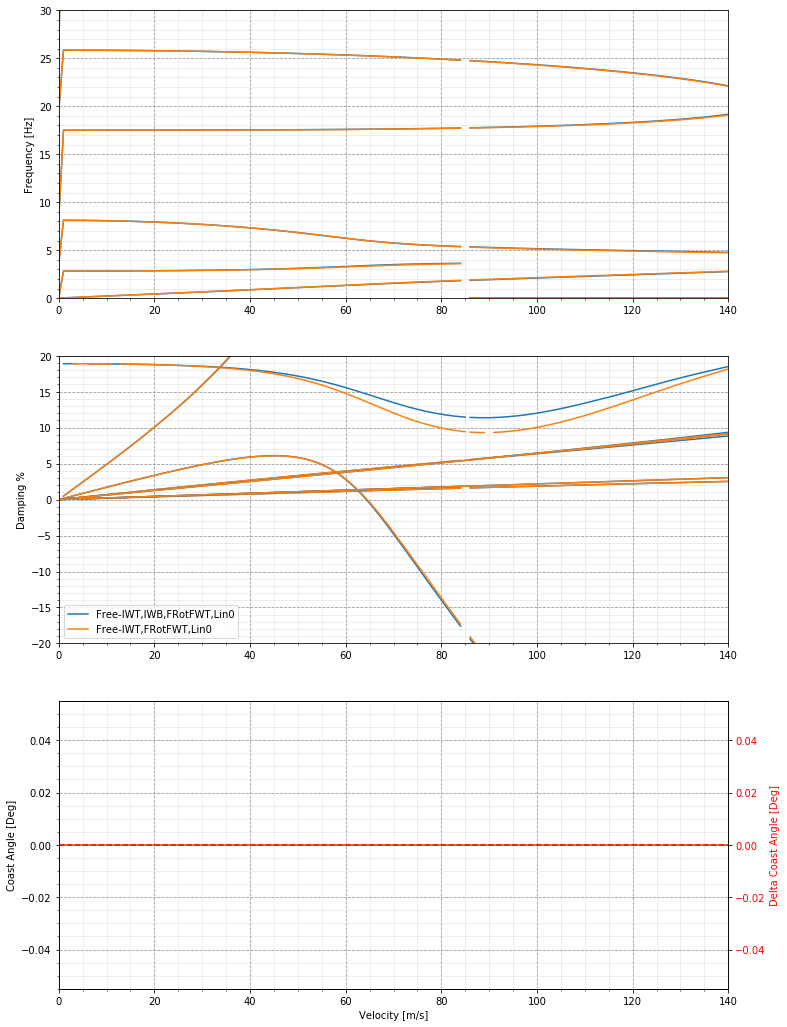

In [156]:
fig, axes = plt.subplots(3,1,figsize=(12,18))    

Tests = [5,6]
data = GetReducedDataSet(flutdf,Tests,Flare = 25)

PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'Test',var = 'Frequency',ax = axes[0])
PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'Test',var = 'Damping [%]',ax = axes[1])
CoastDeltaPlot(data,'Test', axes[2],Delta = True)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,140))
    

axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')

#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,30))
axes[1].set(ylim=(-20,20))    


#PlotModes(data,'Test',axes[:])
axes[1].legend([names[i] for i in Tests])
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

## Compare FWT Ratios

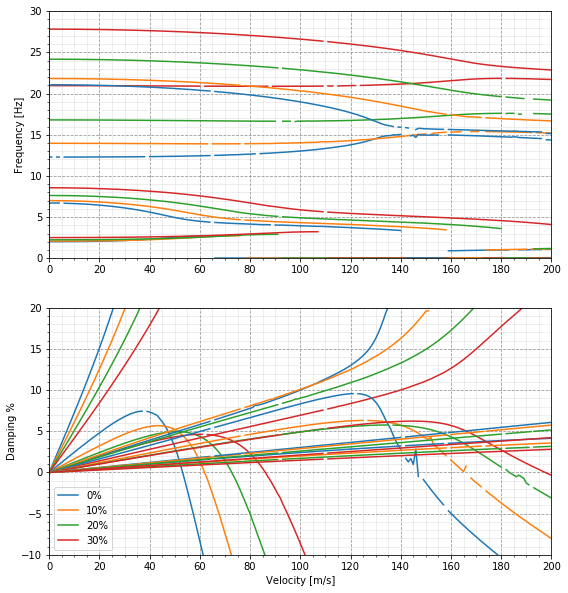

In [125]:
fig, axes = plt.subplots(2,1,figsize=(9,10))    

Tests = [0,4]
data = GetReducedDataSet(flutdf,0,ratio_FWT=[0,10,20,30], Flare = 25,Vmax=200)

#sns.scatterplot(data = data,x='V',y='Frequency',ax=axes[0],s=10,edgecolor='none')
#sns.scatterplot(data = data,x='V',y='Damping [%]',ax=axes[1],s=10,edgecolor='none')

PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'FWT Ratio [%]',var = 'Frequency',ax = axes[0],sigma=5)
PlotLines(data,Modes = flutdf['Mode'].cat.categories,hue = 'FWT Ratio [%]',var = 'Damping [%]',ax = axes[1],sigma=5)

for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,200))
    axes[i].set_xticks([i*20 for i in range(11)])
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,30))
axes[1].set(ylim=(-10,20))    


axes[0].set_ylabel('Frequency [Hz]')
axes[1].set_ylabel('Damping %')
axes[1].set_xlabel('Velocity [m/s]')

#PlotModes(data,'Test',axes[:])
axes[1].legend(['0%','10%','20%','30%'])
#fig.show()
#PlotModes(1,axes[:,0],Flare = 25)

In [146]:
a = [0,1,6,4,1,4]
np.unique(flutdf[flutdf['Mode']==1]['Test'])

array([0, 1, 2, 3, 4, 5, 6])